<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/AI_art_human_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!rm *.csv
#!rm *.png
#!rm -r data

In [2]:
import warnings
warnings.filterwarnings('ignore')

!pip install lightgbm scikit-learn opencv-python matplotlib seaborn kaggle scipy umap-learn -q

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

KAGGLE_JSON = "/content/drive/MyDrive/kaggle.json"
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp "{KAGGLE_JSON}" /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!mkdir -p ./data/art_dataset
!kaggle datasets download -d kausthubkannan/ai-and-human-art-classification -p ./data/art_dataset
!unzip -q -n ./data/art_dataset/ai-and-human-art-classification.zip -d ./data/art_dataset/

# ==================== IMPORTS ====================
import pathlib, random, time, gc, copy
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            roc_curve, precision_recall_fscore_support, accuracy_score,
                            precision_recall_curve, average_precision_score)
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 9
sns.set_palette("colorblind")

SEED = 2509
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/ai-and-human-art-classification
License(s): DbCL-1.0
 99% 2.19G/2.21G [00:17<00:00, 255MB/s]
100% 2.21G/2.21G [00:17<00:00, 137MB/s]


In [3]:
# ==================== CONFIGURATION ====================
DATASET_LIMIT = 10000  # Per class - sufficient for publication
BATCH_SIZE = 16
NUM_WORKERS = 0
NUM_EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# ==================== TIMING SYSTEM ====================
class Timer:
    def __init__(self, name):
        self.name = name
        self.start = None

    def __enter__(self):
        self.start = time.time()
        print(f"\n⏱️  {self.name}...")
        return self

    def __exit__(self, *args):
        elapsed = time.time() - self.start
        print(f"✅ {self.name}: {elapsed:.2f}s ({elapsed/60:.2f}min)")
        return elapsed

timings = {}

# ==================== DATA LOADING ====================
with Timer("Data Loading") as t:
    DATA_ROOT = pathlib.Path("./data/art_dataset/ai_art_classification/train")
    HUMAN_PATH = DATA_ROOT / "NON_AI_GENERATED"
    AI_PATH = DATA_ROOT / "AI_GENERATED"

    from itertools import islice
    human_files = list(islice(HUMAN_PATH.glob("*.jpg"), DATASET_LIMIT))
    ai_files = list(islice(AI_PATH.glob("*.jpg"), DATASET_LIMIT))
    all_files = human_files + ai_files
    labels = [0]*len(human_files) + [1]*len(ai_files)

    train_files, temp_files, train_labels, temp_labels = train_test_split(
        all_files, labels, test_size=0.3, stratify=labels, random_state=SEED
    )
    val_files, test_files, val_labels, test_labels = train_test_split(
        temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED
    )

    print(f"📊 Dataset: {len(all_files)} total | Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

timings['data_loading'] = t.__exit__()


🖥️  Device: cuda

⏱️  Data Loading...
📊 Dataset: 18288 total | Train: 12801 | Val: 2743 | Test: 2744
✅ Data Loading: 0.24s (0.00min)
✅ Data Loading: 0.24s (0.00min)



📊 Generating Figure 5: Data Augmentation Examples...


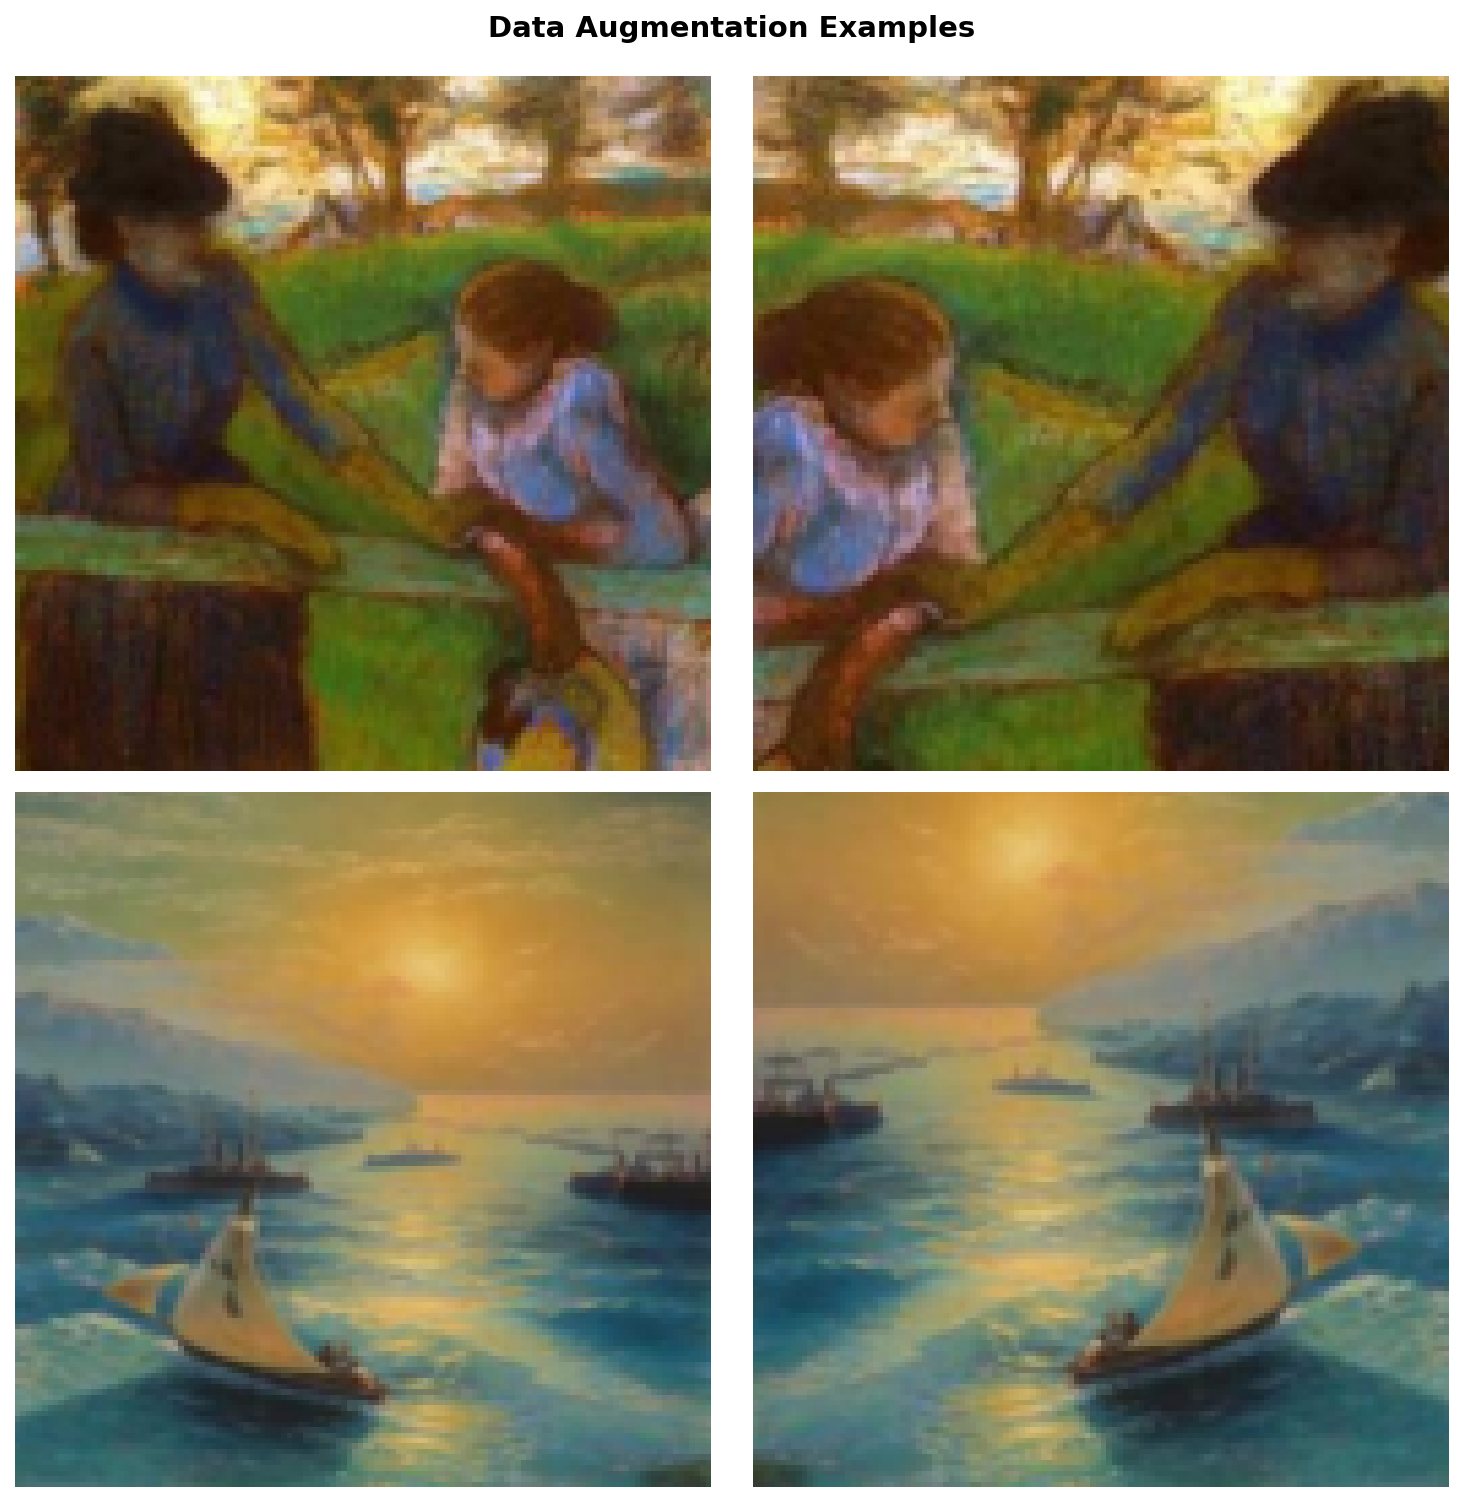

5862

In [11]:
# ==================== FIGURE 5: AUGMENTATION VISUALIZATION ====================
print("\n📊 Generating Figure 5: Data Augmentation Examples...")

# Define augmentation transforms
transform_no_aug = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

transform_standard_aug = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),  # Force flip for visualization
    transforms.ToTensor(),
])

# Select 6 diverse samples (2 human traditional, 2 human digital, 2 AI)
sample_files = [
    human_files[1],      # Human traditional 1
    human_files[500],    # Human traditional 2
    human_files[1500]   # Human digital 1
]

sample_labels = [
    "Human Art",
    "Human Art" ]

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, (img_path, label) in enumerate(zip(sample_files, sample_labels)):
    try:
        # Load original image
        img = Image.open(img_path).convert('RGB')

        # Original (no augmentation)
        img_tensor_orig = transform_no_aug(img)
        img_display_orig = transforms.ToPILImage()(img_tensor_orig)
        axes[i, 0].imshow(img_display_orig)
        axes[i, 0].axis('off')

        # Augmented (crop + flip)
        img_tensor_aug = transform_standard_aug(img)
        img_display_aug = transforms.ToPILImage()(img_tensor_aug)
        axes[i, 1].imshow(img_display_aug)
        axes[i, 1].axis('off')

    except Exception as e:
        print(f"  Warning: Could not load image {i}: {e}")
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

plt.suptitle('Data Augmentation Examples',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('figure5_augmentation_examples.png', dpi=1200, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

In [12]:

# ==================== HANDCRAFTED FEATURES ====================
def extract_features(img_path):
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))

        features = []

        # Color stats (15 features)
        for ch in range(3):
            c = img[:,:,ch]
            features.extend([c.mean(), c.std(), np.median(c),
                           stats.skew(c.flatten()), stats.kurtosis(c.flatten())])

        # Texture (3 features)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist = hist / (hist.sum() + 1e-7)
        entropy = -np.sum(hist * np.log2(hist + 1e-7))
        features.extend([entropy, gray.std(), cv2.Laplacian(gray, cv2.CV_64F).var()])

        # NOVEL: Frequency domain (3 features)
        dct = cv2.dct(np.float32(gray))
        h, w = dct.shape
        high_freq = np.abs(dct[h//2:, w//2:]).sum() / (h * w)
        low_freq = np.abs(dct[:h//2, :w//2]).sum() / (h * w)
        freq_ratio = high_freq / (low_freq + 1e-7)
        features.extend([high_freq, low_freq, freq_ratio])

        # Edges (2 features)
        edges = cv2.Canny(gray, 50, 150)
        features.extend([edges.mean(), edges.sum() / (h * w)])

        return np.array(features, dtype=np.float32)
    except:
        return None

feature_names = [
    'R_mean', 'R_std', 'R_med', 'R_skew', 'R_kurt',
    'G_mean', 'G_std', 'G_med', 'G_skew', 'G_kurt',
    'B_mean', 'B_std', 'B_med', 'B_skew', 'B_kurt',
    'Entropy', 'Contrast', 'Laplacian',
    'High_freq', 'Low_freq', 'Freq_ratio', 'Edge_density', 'Edge_smooth'
]

with Timer("Handcrafted Feature Extraction") as t:
    def extract_batch(files):
        return np.array([f for f in [extract_features(fp) for fp in tqdm(files, leave=False, desc="Extracting")] if f is not None])

    X_train_hand = extract_batch(train_files)
    X_val_hand = extract_batch(val_files)
    X_test_hand = extract_batch(test_files)

    scaler = StandardScaler()
    X_train_hand = scaler.fit_transform(X_train_hand)
    X_val_hand = scaler.transform(X_val_hand)
    X_test_hand = scaler.transform(X_test_hand)

    print(f"📐 Handcrafted features: {X_train_hand.shape}")
    gc.collect()

timings['handcrafted_extraction'] = t.__exit__()

# ==================== CNN FEATURES ====================
with Timer("CNN Feature Extraction") as t:
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    feature_net = models.mobilenet_v2(weights='IMAGENET1K_V1')
    feature_net.classifier = nn.Identity()
    feature_net.eval().to(device)

    def extract_cnn_batch(files, batch_size=16):
        all_feats = []
        with torch.no_grad():
            for i in tqdm(range(0, len(files), batch_size), leave=False, desc="CNN features"):
                batch = files[i:i+batch_size]
                tensors = []
                for f in batch:
                    try:
                        tensors.append(transform(Image.open(f).convert("RGB")))
                    except:
                        continue
                if tensors:
                    batch_t = torch.stack(tensors).to(device)
                    all_feats.append(feature_net(batch_t).cpu().numpy())
                    del batch_t
                if i % 100 == 0:
                    torch.cuda.empty_cache()
        return np.vstack(all_feats).astype(np.float32)

    X_train_cnn = extract_cnn_batch(train_files)
    X_val_cnn = extract_cnn_batch(val_files)
    X_test_cnn = extract_cnn_batch(test_files)

    del feature_net
    gc.collect()
    torch.cuda.empty_cache()

    print(f"🧠 CNN features: {X_train_cnn.shape}")

timings['cnn_extraction'] = t.__exit__()

# ==================== METHOD 1: HANDCRAFTED + RF ====================
print("\n" + "="*70)
print("METHOD 1: Handcrafted Features + Random Forest")
print("="*70)

with Timer("Method 1 Training") as t:
    rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_model.fit(X_train_hand, train_labels)

timings['method1_train'] = t.__exit__()

with Timer("Method 1 Inference") as t:
    pred_rf = rf_model.predict(X_test_hand)
    prob_rf = rf_model.predict_proba(X_test_hand)[:, 1]

timings['method1_inference'] = t.__exit__()

p, r, f1_rf, _ = precision_recall_fscore_support(test_labels, pred_rf, average='binary')
acc_rf = accuracy_score(test_labels, pred_rf)
roc_rf = roc_auc_score(test_labels, prob_rf)
print(f"📊 F1={f1_rf:.4f} | Acc={acc_rf:.4f} | ROC-AUC={roc_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# ==================== METHOD 2: ATTENTION FUSION ====================
print("\n" + "="*70)
print("METHOD 2: Attention Fusion (NOVEL)")
print("="*70)

class AttentionFusion(nn.Module):
    def __init__(self, hand_dim, cnn_dim, hidden=64):
        super().__init__()
        self.hand_proj = nn.Linear(hand_dim, hidden)
        self.cnn_proj = nn.Linear(cnn_dim, hidden)
        self.attention = nn.Sequential(
            nn.Linear(hidden * 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 2),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, hand, cnn, return_hidden=False):
        h = F.relu(self.hand_proj(hand))
        c = F.relu(self.cnn_proj(cnn))
        attn = self.attention(torch.cat([h, c], 1))
        fused = attn[:, 0:1] * h + attn[:, 1:2] * c
        out = self.classifier(fused)
        if return_hidden:
            return out, attn, fused
        return out, attn

class FusionDataset(Dataset):
    def __init__(self, hand, cnn, labels):
        self.hand = torch.FloatTensor(hand)
        self.cnn = torch.FloatTensor(cnn)
        self.labels = torch.LongTensor(labels)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, i):
        return self.hand[i], self.cnn[i], self.labels[i]

train_ds = FusionDataset(X_train_hand, X_train_cnn, train_labels)
val_ds = FusionDataset(X_val_hand, X_val_cnn, val_labels)
test_ds = FusionDataset(X_test_hand, X_test_cnn, test_labels)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader_fusion = DataLoader(test_ds, batch_size=64, shuffle=False)

fusion_model = AttentionFusion(X_train_hand.shape[1], X_train_cnn.shape[1]).to(device)
optimizer = torch.optim.AdamW(fusion_model.parameters(), lr=1e-3, weight_decay=1e-4)

with Timer("Method 2 Training") as t:
    best_f1 = 0
    for epoch in range(1, 6):
        fusion_model.train()
        for hand, cnn, labels in train_loader:
            hand, cnn, labels = hand.to(device), cnn.to(device), labels.to(device)
            optimizer.zero_grad()
            out, _ = fusion_model(hand, cnn)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

        fusion_model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for hand, cnn, labels in val_loader:
                hand, cnn = hand.to(device), cnn.to(device)
                out, _ = fusion_model(hand, cnn)
                preds.append(out.argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state = copy.deepcopy(fusion_model.state_dict())

    fusion_model.load_state_dict(best_state)

timings['method2_train'] = t.__exit__()

with Timer("Method 2 Inference") as t:
    fusion_model.eval()
    pred_fusion, prob_fusion, attn_weights, fusion_features = [], [], [], []
    with torch.no_grad():
        for hand, cnn, labels in test_loader_fusion:
            hand, cnn = hand.to(device), cnn.to(device)
            out, attn, fused = fusion_model(hand, cnn, return_hidden=True)
            prob_fusion.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_fusion.append(out.argmax(1).cpu().numpy())
            attn_weights.append(attn.cpu().numpy())
            fusion_features.append(fused.cpu().numpy())

    pred_fusion = np.concatenate(pred_fusion)
    prob_fusion = np.concatenate(prob_fusion)
    attn_weights = np.concatenate(attn_weights)
    fusion_features = np.concatenate(fusion_features)

timings['method2_inference'] = t.__exit__()

p, r, f1_fusion, _ = precision_recall_fscore_support(test_labels, pred_fusion, average='binary')
acc_fusion = accuracy_score(test_labels, pred_fusion)
roc_fusion = roc_auc_score(test_labels, prob_fusion)
print(f"📊 F1={f1_fusion:.4f} | Acc={acc_fusion:.4f} | ROC-AUC={roc_fusion:.4f}")

del fusion_model
gc.collect()
torch.cuda.empty_cache()




⏱️  Handcrafted Feature Extraction...


Extracting:   0%|          | 0/12801 [00:00<?, ?it/s]

Extracting:   0%|          | 0/2743 [00:00<?, ?it/s]

Extracting:   0%|          | 0/2744 [00:00<?, ?it/s]

📐 Handcrafted features: (12801, 23)
✅ Handcrafted Feature Extraction: 186.26s (3.10min)
✅ Handcrafted Feature Extraction: 186.26s (3.10min)

⏱️  CNN Feature Extraction...


CNN features:   0%|          | 0/801 [00:00<?, ?it/s]

CNN features:   0%|          | 0/172 [00:00<?, ?it/s]

CNN features:   0%|          | 0/172 [00:00<?, ?it/s]

🧠 CNN features: (12801, 1280)
✅ CNN Feature Extraction: 83.10s (1.38min)
✅ CNN Feature Extraction: 83.10s (1.38min)

METHOD 1: Handcrafted Features + Random Forest

⏱️  Method 1 Training...
✅ Method 1 Training: 4.71s (0.08min)
✅ Method 1 Training: 4.71s (0.08min)

⏱️  Method 1 Inference...
✅ Method 1 Inference: 0.09s (0.00min)
✅ Method 1 Inference: 0.09s (0.00min)
📊 F1=0.8155 | Acc=0.7956 | ROC-AUC=0.8739

🔍 Top 10 Most Important Features:
     Feature  Importance
    Low_freq    0.068645
 Edge_smooth    0.065835
Edge_density    0.065089
       G_std    0.063943
       B_std    0.053628
    Contrast    0.052730
      R_mean    0.052088
      G_mean    0.051532
     Entropy    0.046871
       R_std    0.045819

METHOD 2: Attention Fusion (NOVEL)

⏱️  Method 2 Training...
  Epoch 1: Val F1=0.8828
  Epoch 2: Val F1=0.8918
  Epoch 3: Val F1=0.8932
  Epoch 4: Val F1=0.8984
  Epoch 5: Val F1=0.8864
✅ Method 2 Training: 4.01s (0.07min)
✅ Method 2 Training: 4.01s (0.07min)

⏱️  Method 2 Infere

In [ ]:
# ==================== METHOD 3: RESNET50 ====================
print("\n" + "="*70)
print("METHOD 3: ResNet50")
print("="*70)

class ImageDataset(Dataset):
    def __init__(self, files, labels, transform):
        self.files = files
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.transform(img), self.labels[i]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds_img = ImageDataset(train_files, train_labels, transform_train)
val_ds_img = ImageDataset(val_files, val_labels, transform_test)
test_ds_img = ImageDataset(test_files, test_labels, transform_test)

train_loader_img = DataLoader(train_ds_img, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_img = DataLoader(val_ds_img, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_resnet = DataLoader(test_ds_img, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

resnet = models.resnet50(weights='IMAGENET1K_V2')
resnet.fc = nn.Linear(resnet.fc.in_features, 2)
resnet = resnet.to(device)
optimizer_resnet = torch.optim.AdamW(resnet.parameters(), lr=1e-4, weight_decay=1e-4)

with Timer("Method 3 Training") as t:
    best_f1 = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        resnet.train()
        for imgs, labels in tqdm(train_loader_img, desc=f"Epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_resnet.zero_grad()
            out = resnet(imgs)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_resnet.step()

        resnet.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, labels in val_loader_img:
                imgs = imgs.to(device)
                preds.append(resnet(imgs).argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state_resnet = copy.deepcopy(resnet.state_dict())

        torch.cuda.empty_cache()

    resnet.load_state_dict(best_state_resnet)

timings['method3_train'] = t.__exit__()

# Extract ResNet features for visualization
resnet_penultimate = nn.Sequential(*list(resnet.children())[:-1])
resnet_penultimate.eval()

with Timer("Method 3 Inference") as t:
    pred_resnet, prob_resnet, resnet_features = [], [], []
    with torch.no_grad():
        for imgs, labels in test_loader_resnet:
            imgs = imgs.to(device)
            out = resnet(imgs)
            feats = resnet_penultimate(imgs).squeeze()
            if feats.dim() == 1:  # Handle single sample case
                feats = feats.unsqueeze(0)
            prob_resnet.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_resnet.append(out.argmax(1).cpu().numpy())
            resnet_features.append(feats.cpu().numpy())

    pred_resnet = np.concatenate(pred_resnet)
    prob_resnet = np.concatenate(prob_resnet)
    resnet_features = np.vstack(resnet_features)

timings['method3_inference'] = t.__exit__()

p, r, f1_resnet, _ = precision_recall_fscore_support(test_labels, pred_resnet, average='binary')
acc_resnet = accuracy_score(test_labels, pred_resnet)
roc_resnet = roc_auc_score(test_labels, prob_resnet)
print(f"📊 F1={f1_resnet:.4f} | Acc={acc_resnet:.4f} | ROC-AUC={roc_resnet:.4f}")

del resnet, resnet_penultimate
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ==================== METHOD 4: VISION TRANSFORMER ====================
print("\n" + "="*70)
print("METHOD 4: Vision Transformer (ViT-B/16)")
print("="*70)

# Create FRESH datasets and dataloaders for ViT with 224x224 images
transform_train_vit = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Changed from 128 to 224 for ViT
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test_vit = transforms.Compose([
    transforms.Resize((224, 224)),  # Changed from 128 to 224 for ViT
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds_img_vit = ImageDataset(train_files, train_labels, transform_train_vit)
val_ds_img_vit = ImageDataset(val_files, val_labels, transform_test_vit)
test_ds_img_vit = ImageDataset(test_files, test_labels, transform_test_vit)

train_loader_vit = DataLoader(train_ds_img_vit, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_vit = DataLoader(val_ds_img_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_vit = DataLoader(test_ds_img_vit, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

vit = models.vit_b_16(weights='IMAGENET1K_V1')
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)
vit = vit.to(device)
optimizer_vit = torch.optim.AdamW(vit.parameters(), lr=1e-4, weight_decay=1e-4)

with Timer("Method 4 Training") as t:
    best_f1 = 0
    for epoch in range(1, NUM_EPOCHS + 1):
        vit.train()
        for imgs, labels in tqdm(train_loader_vit, desc=f"Epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_vit.zero_grad()
            out = vit(imgs)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_vit.step()

        vit.eval()
        preds, targets = [], []
        with torch.no_grad():
            for imgs, labels in val_loader_vit:
                imgs = imgs.to(device)
                preds.append(vit(imgs).argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds, targets = np.concatenate(preds), np.concatenate(targets)
        f1 = precision_recall_fscore_support(targets, preds, average='binary')[2]
        print(f"  Epoch {epoch}: Val F1={f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_state_vit = copy.deepcopy(vit.state_dict())

        torch.cuda.empty_cache()

    vit.load_state_dict(best_state_vit)

timings['method4_train'] = t.__exit__()

with Timer("Method 4 Inference") as t:
    pred_vit, prob_vit = [], []
    with torch.no_grad():
        for imgs, labels in test_loader_vit:
            imgs = imgs.to(device)
            out = vit(imgs)
            prob_vit.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_vit.append(out.argmax(1).cpu().numpy())

    pred_vit = np.concatenate(pred_vit)
    prob_vit = np.concatenate(prob_vit)

timings['method4_inference'] = t.__exit__()

p, r, f1_vit, _ = precision_recall_fscore_support(test_labels, pred_vit, average='binary')
acc_vit = accuracy_score(test_labels, pred_vit)
roc_vit = roc_auc_score(test_labels, prob_vit)
print(f"📊 F1={f1_vit:.4f} | Acc={acc_vit:.4f} | ROC-AUC={roc_vit:.4f}")

del vit
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ======================================================================
# METHOD 5: ResNet50 (Frozen) + Handcrafted Attention Fusion
# ======================================================================
print("\n" + "="*70)
print("METHOD 5: ResNet50 (Frozen Pretrained) + Handcrafted Fusion")
print("="*70)

# ============================================================
# 1. Load FROZEN ResNet50 (pre-trained, never fine-tuned)
# ============================================================
print("Loading frozen pre-trained ResNet50...")
resnet50_frozen = models.resnet50(weights='IMAGENET1K_V2')
# Remove final classification layer
resnet50_feature_extractor = nn.Sequential(*list(resnet50_frozen.children())[:-1])
resnet50_feature_extractor.eval()
resnet50_feature_extractor.to(device)

# Freeze all parameters
for param in resnet50_feature_extractor.parameters():
    param.requires_grad = False

# Transform for ResNet (same as before)
resnet_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ============================================================
# 2. Extract ResNet Features (IN CORRECT ORDER)
# ============================================================
def extract_resnet_features_batch(file_list, transform, model, device, batch_size=32):
    """Extract features in batches while maintaining order"""
    all_features = []

    with torch.no_grad():
        for i in tqdm(range(0, len(file_list), batch_size), desc="Extracting ResNet features", leave=False):
            batch_files = file_list[i:i+batch_size]
            batch_tensors = []

            for f in batch_files:
                try:
                    img = Image.open(f).convert("RGB")
                    tensor = transform(img)
                    batch_tensors.append(tensor)
                except:
                    # Handle corrupted images - use zero tensor
                    batch_tensors.append(torch.zeros(3, 128, 128))

            if batch_tensors:
                batch_t = torch.stack(batch_tensors).to(device)
                features = model(batch_t).squeeze()  # Remove spatial dimensions

                # Handle single sample case
                if features.dim() == 1:
                    features = features.unsqueeze(0)

                all_features.append(features.cpu().numpy())

                # Clear GPU memory periodically
                if i % 100 == 0:
                    torch.cuda.empty_cache()

    return np.vstack(all_features).astype(np.float32)

with Timer("ResNet50 Frozen Feature Extraction") as t:
    X_train_resnet_frozen = extract_resnet_features_batch(
        train_files, resnet_transform, resnet50_feature_extractor, device
    )
    X_val_resnet_frozen = extract_resnet_features_batch(
        val_files, resnet_transform, resnet50_feature_extractor, device
    )
    X_test_resnet_frozen = extract_resnet_features_batch(
        test_files, resnet_transform, resnet50_feature_extractor, device
    )
    timings["resnet_frozen_extraction"] = t.__exit__()

print(f"✓ ResNet50 frozen features extracted:")
print(f"  Train: {X_train_resnet_frozen.shape}")
print(f"  Val:   {X_val_resnet_frozen.shape}")
print(f"  Test:  {X_test_resnet_frozen.shape}")

# Verify alignment
assert len(X_train_resnet_frozen) == len(train_labels), "Train set size mismatch!"
assert len(X_test_resnet_frozen) == len(test_labels), "Test set size mismatch!"

# ============================================================
# 3. Create Fusion Datasets
# ============================================================
train_ds_resnet_fusion = FusionDataset(X_train_hand, X_train_resnet_frozen, train_labels)
val_ds_resnet_fusion = FusionDataset(X_val_hand, X_val_resnet_frozen, val_labels)
test_ds_resnet_fusion = FusionDataset(X_test_hand, X_test_resnet_frozen, test_labels)

train_loader_resnet_fusion = DataLoader(train_ds_resnet_fusion, batch_size=64, shuffle=True)
val_loader_resnet_fusion = DataLoader(val_ds_resnet_fusion, batch_size=64, shuffle=False)
test_loader_resnet_fusion = DataLoader(test_ds_resnet_fusion, batch_size=64, shuffle=False)

# ============================================================
# 4. Define Fusion Model (using your AttentionFusion class)
# ============================================================
fusion_resnet50 = AttentionFusion(
    hand_dim=X_train_hand.shape[1],  # 23
    cnn_dim=2048,  # ResNet50 feature dimension
    hidden=64
).to(device)

optimizer_resnet_fusion = torch.optim.AdamW(
    fusion_resnet50.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# ============================================================
# 5. Train Fusion Model
# ============================================================
best_f1_resnet_fusion = 0
best_state_resnet_fusion = copy.deepcopy(fusion_resnet50.state_dict())

with Timer("Method 5 Training") as t:
    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        fusion_resnet50.train()
        for hand, resnet_feat, labels in train_loader_resnet_fusion:
            hand = hand.to(device)
            resnet_feat = resnet_feat.to(device)
            labels = labels.to(device)

            optimizer_resnet_fusion.zero_grad()
            out, _ = fusion_resnet50(hand, resnet_feat)
            loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer_resnet_fusion.step()

        # Validation
        fusion_resnet50.eval()
        preds, targets = [], []
        with torch.no_grad():
            for hand, resnet_feat, labels in val_loader_resnet_fusion:
                hand = hand.to(device)
                resnet_feat = resnet_feat.to(device)
                out, _ = fusion_resnet50(hand, resnet_feat)
                preds.append(out.argmax(1).cpu().numpy())
                targets.append(labels.numpy())

        preds = np.concatenate(preds)
        targets = np.concatenate(targets)
        f1_val = precision_recall_fscore_support(targets, preds, average="binary")[2]

        print(f"  Epoch {epoch}: Val F1 = {f1_val:.4f}")

        if f1_val > best_f1_resnet_fusion:
            best_f1_resnet_fusion = f1_val
            best_state_resnet_fusion = copy.deepcopy(fusion_resnet50.state_dict())

    timings["method5_train"] = t.__exit__()

# Load best model
fusion_resnet50.load_state_dict(best_state_resnet_fusion)

# ============================================================
# 6. Test Performance
# ============================================================
with Timer("Method 5 Inference") as t:
    fusion_resnet50.eval()
    pred_resnet_fusion, prob_resnet_fusion = [], []

    with torch.no_grad():
        for hand, resnet_feat, labels in test_loader_resnet_fusion:
            hand = hand.to(device)
            resnet_feat = resnet_feat.to(device)
            out, _ = fusion_resnet50(hand, resnet_feat)
            prob_resnet_fusion.append(F.softmax(out, dim=1)[:, 1].cpu().numpy())
            pred_resnet_fusion.append(out.argmax(1).cpu().numpy())

    timings["method5_inference"] = t.__exit__()

pred_resnet_fusion = np.concatenate(pred_resnet_fusion)
prob_resnet_fusion = np.concatenate(prob_resnet_fusion)

# Calculate metrics
p_rf, r_rf, f1_resnet_fusion, _ = precision_recall_fscore_support(
    test_labels, pred_resnet_fusion, average="binary"
)
acc_resnet_fusion = accuracy_score(test_labels, pred_resnet_fusion)
roc_resnet_fusion = roc_auc_score(test_labels, prob_resnet_fusion)

print(f"\n📊 ResNet50 (Frozen) + Fusion Performance:")
print(f"  F1-score:  {f1_resnet_fusion:.4f}")
print(f"  Accuracy:  {acc_resnet_fusion:.4f}")
print(f"  Precision: {p_rf:.4f}")
print(f"  Recall:    {r_rf:.4f}")
print(f"  ROC-AUC:   {roc_resnet_fusion:.4f}")

# Clean up
del resnet50_frozen, resnet50_feature_extractor, fusion_resnet50
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# ==================== MISSING BASELINES: RESNET50 VARIANTS ====================
print("\n" + "="*70)
print("ADDITIONAL BASELINES: ResNet50 Feature Variants")
print("="*70)

# Baseline 1: ResNet50 (Frozen) + Random Forest
print("\n[Baseline 1] ResNet50 Frozen Features + Random Forest")
with Timer("ResNet50 Frozen + RF Training") as t:
    rf_resnet_frozen = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_resnet_frozen.fit(X_train_resnet_frozen, train_labels)
    timings['resnet_frozen_rf_train'] = t.__exit__()

with Timer("ResNet50 Frozen + RF Inference") as t:
    pred_rf_resnet = rf_resnet_frozen.predict(X_test_resnet_frozen)
    prob_rf_resnet = rf_resnet_frozen.predict_proba(X_test_resnet_frozen)[:, 1]
    timings['resnet_frozen_rf_inference'] = t.__exit__()

p_rfr, r_rfr, f1_rf_resnet, _ = precision_recall_fscore_support(test_labels, pred_rf_resnet, average='binary')
acc_rf_resnet = accuracy_score(test_labels, pred_rf_resnet)
roc_rf_resnet = roc_auc_score(test_labels, prob_rf_resnet)

print(f"📊 F1={f1_rf_resnet:.4f} | Acc={acc_rf_resnet:.4f} | ROC-AUC={roc_rf_resnet:.4f}")

# Baseline 2: ResNet50 + Handcrafted Concatenation + Random Forest
print("\n[Baseline 2] ResNet50 + Handcrafted Concatenation + Random Forest")
X_train_concat_resnet = np.hstack([X_train_hand, X_train_resnet_frozen])
X_test_concat_resnet = np.hstack([X_test_hand, X_test_resnet_frozen])

with Timer("ResNet50 Concatenation + RF Training") as t:
    rf_concat_resnet = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_concat_resnet.fit(X_train_concat_resnet, train_labels)
    timings['resnet_concat_rf_train'] = t.__exit__()

with Timer("ResNet50 Concatenation + RF Inference") as t:
    pred_concat_resnet = rf_concat_resnet.predict(X_test_concat_resnet)
    prob_concat_resnet = rf_concat_resnet.predict_proba(X_test_concat_resnet)[:, 1]
    timings['resnet_concat_rf_inference'] = t.__exit__()

p_rcr, r_rcr, f1_concat_resnet, _ = precision_recall_fscore_support(test_labels, pred_concat_resnet, average='binary')
acc_concat_resnet = accuracy_score(test_labels, pred_concat_resnet)
roc_concat_resnet = roc_auc_score(test_labels, prob_concat_resnet)

print(f"📊 F1={f1_concat_resnet:.4f} | Acc={acc_concat_resnet:.4f} | ROC-AUC={roc_concat_resnet:.4f}")

del rf_resnet_frozen, rf_concat_resnet
gc.collect()

In [ ]:
# ==================== FAIR COMPARISON TABLE ====================
print("\n" + "="*70)
print("FAIR COMPARISON (Including Feature Extraction Time)")
print("="*70)

results_df = pd.DataFrame([
    {
        'Method': 'Handcrafted + RF',
        'F1': f1_rf,
        'Accuracy': acc_rf,
        'ROC-AUC': roc_rf,
        'Feature Extraction (s)': timings['handcrafted_extraction'],
        'Training (s)': timings['method1_train'],
        'Inference (s)': timings['method1_inference'],
        'Total Pipeline (s)': timings['handcrafted_extraction'] + timings['method1_train']
    },
    {
        'Method': 'Attention Fusion (Ours)',
        'F1': f1_fusion,
        'Accuracy': acc_fusion,
        'ROC-AUC': roc_fusion,
        'Feature Extraction (s)': timings['handcrafted_extraction'] + timings['cnn_extraction'],
        'Training (s)': timings['method2_train'],
        'Inference (s)': timings['method2_inference'],
        'Total Pipeline (s)': timings['handcrafted_extraction'] + timings['cnn_extraction'] + timings['method2_train']
    },
    {
        'Method': 'ResNet50',
        'F1': f1_resnet,
        'Accuracy': acc_resnet,
        'ROC-AUC': roc_resnet,
        'Feature Extraction (s)': 0,
        'Training (s)': timings['method3_train'],
        'Inference (s)': timings['method3_inference'],
        'Total Pipeline (s)': timings['method3_train']
    },
    {
        'Method': 'ViT-B/16',
        'F1': f1_vit,
        'Accuracy': acc_vit,
        'ROC-AUC': roc_vit,
        'Feature Extraction (s)': 0,
        'Training (s)': timings['method4_train'],
        'Inference (s)': timings['method4_inference'],
        'Total Pipeline (s)': timings['method4_train']
    }
])

print(results_df.to_string(index=False))
results_df.to_csv('fair_comparison_results.csv', index=False)

# Calculate speedup
resnet_time = results_df[results_df['Method'] == 'ResNet50']['Total Pipeline (s)'].values[0]
fusion_time = results_df[results_df['Method'] == 'Attention Fusion (Ours)']['Total Pipeline (s)'].values[0]
speedup = resnet_time / fusion_time

print(f"\n🚀 SPEEDUP: Attention Fusion is {speedup:.1f}× faster than ResNet50!")
print(f"📉 F1 Trade-off: {(f1_resnet - f1_fusion)*100:.1f}% accuracy loss for {speedup:.1f}× speedup")

# ==================== VISUALIZATION 1: COMPREHENSIVE COMPARISON ====================
print("\n📊 Generating Figure 1: Comprehensive Comparison...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Row 1: Confusion Matrices
methods_data = [
    ('Handcrafted+RF', test_labels, pred_rf),
    ('Attention Fusion', test_labels, pred_fusion),
    ('ResNet50', test_labels, pred_resnet),
    ('ViT-B/16', test_labels, pred_vit)
]

for idx, (name, true, pred) in enumerate(methods_data):
    ax = fig.add_subplot(gs[0, idx])
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
    ax.set_title(f'{name}\nConfusion Matrix', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

# Row 2: ROC Curves and Performance Metrics
ax_roc = fig.add_subplot(gs[1, :2])
for true, prob, name, color in [
    (test_labels, prob_rf, 'Handcrafted+RF', '#1f77b4'),
    (test_labels, prob_fusion, 'Attention Fusion', '#d62728'),
    (test_labels, prob_resnet, 'ResNet50', '#2ca02c'),
    (test_labels, prob_vit, 'ViT-B/16', '#ff7f0e')
]:
    fpr, tpr, _ = roc_curve(true, prob)
    auc = roc_auc_score(true, prob)
    ax_roc.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', lw=2, color=color)

ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
ax_roc.set_xlabel('False Positive Rate', fontweight='bold')
ax_roc.set_ylabel('True Positive Rate', fontweight='bold')
ax_roc.set_title('ROC Curves Comparison', fontsize=11, fontweight='bold')
ax_roc.legend(loc='lower right', fontsize=8)
ax_roc.grid(alpha=0.3)

# Performance Metrics Comparison
ax_perf = fig.add_subplot(gs[1, 2:])
metrics = ['F1', 'Accuracy', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.2
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

for i, (method_name, color) in enumerate([
    ('Handcrafted + RF', colors[0]),
    ('Attention Fusion (Ours)', colors[1]),
    ('ResNet50', colors[2]),
    ('ViT-B/16', colors[3])
]):
    values = results_df[results_df['Method'] == method_name][metrics].values[0]
    ax_perf.bar(x + i * width - 0.3, values, width, label=method_name, color=color, alpha=0.8)

ax_perf.set_ylabel('Score', fontweight='bold')
ax_perf.set_title('Performance Metrics Comparison', fontsize=11, fontweight='bold')
ax_perf.set_xticks(x)
ax_perf.set_xticklabels(metrics)
ax_perf.legend(fontsize=7, loc='lower right')
ax_perf.set_ylim([0.65, 1.0])
ax_perf.grid(axis='y', alpha=0.3)

# Row 3: Computational Efficiency Analysis
ax_time = fig.add_subplot(gs[2, :2])
methods = results_df['Method'].values
total_times = results_df['Total Pipeline (s)'].values / 60  # Convert to minutes

bars = ax_time.barh(methods, total_times, color=['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e'], alpha=0.8)
ax_time.set_xlabel('Total Time (minutes)', fontweight='bold')
ax_time.set_title('Computational Efficiency: Total Pipeline Time', fontsize=11, fontweight='bold')
ax_time.grid(axis='x', alpha=0.3)

for bar, time_val in zip(bars, total_times):
    ax_time.text(time_val + 0.1, bar.get_y() + bar.get_height()/2,
                 f'{time_val:.1f} min', va='center', fontsize=8)

# Accuracy vs Time Trade-off
ax_tradeoff = fig.add_subplot(gs[2, 2:])
f1_scores = results_df['F1'].values
total_times_sec = results_df['Total Pipeline (s)'].values

for i, (method, color) in enumerate([
    ('Handcrafted + RF', colors[0]),
    ('Attention Fusion', colors[1]),
    ('ResNet50', colors[2]),
    ('ViT-B/16', colors[3])
]):
    ax_tradeoff.scatter(total_times_sec[i], f1_scores[i], s=200, color=color,
                       alpha=0.7, edgecolors='black', linewidth=1.5, label=method)
    ax_tradeoff.annotate(method, (total_times_sec[i], f1_scores[i]),
                        xytext=(10, 5), textcoords='offset points', fontsize=7)

ax_tradeoff.set_xlabel('Total Pipeline Time (seconds)', fontweight='bold')
ax_tradeoff.set_ylabel('F1 Score', fontweight='bold')
ax_tradeoff.set_title('Accuracy vs Computational Cost Trade-off', fontsize=11, fontweight='bold')
ax_tradeoff.grid(alpha=0.3)

plt.suptitle('Comprehensive Method Comparison: AI-Generated Art Detection',
             fontsize=14, fontweight='bold', y=0.995)
plt.savefig('figure1_comprehensive_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 2: FEATURE ANALYSIS ====================
print("\n📊 Generating Figure 2: Feature Analysis & Interpretability...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Feature Importance
ax = axes[0, 0]
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['Importance'].values, color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values, fontsize=8)
ax.set_xlabel('Importance', fontweight='bold')
ax.set_title('Top 10 Discriminative Features\n(Random Forest)', fontsize=10, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Highlight frequency features
for i, feat in enumerate(top_features['Feature'].values):
    if 'freq' in feat.lower() or 'Freq' in feat:
        ax.get_yticklabels()[i].set_color('red')
        ax.get_yticklabels()[i].set_weight('bold')

# 2. Attention Weights Distribution
ax = axes[0, 1]
hand_attn = attn_weights[:, 0]
cnn_attn = attn_weights[:, 1]

ax.hist(hand_attn, bins=30, alpha=0.7, label='Handcrafted Features', color='#2ecc71', edgecolor='black')
ax.hist(cnn_attn, bins=30, alpha=0.7, label='CNN Features', color='#9b59b6', edgecolor='black')
ax.set_xlabel('Attention Weight', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Learned Attention Distribution\n(NOVEL: Fusion Mechanism)', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

print(f"  Mean attention - Handcrafted: {hand_attn.mean():.3f}, CNN: {cnn_attn.mean():.3f}")

# 3. Attention by Correctness
ax = axes[0, 2]
correct_mask = (pred_fusion == test_labels)
incorrect_mask = ~correct_mask

ax.scatter(hand_attn[correct_mask], cnn_attn[correct_mask],
          alpha=0.5, s=20, color='green', label='Correct', edgecolors='none')
ax.scatter(hand_attn[incorrect_mask], cnn_attn[incorrect_mask],
          alpha=0.8, s=40, color='red', label='Incorrect', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Handcrafted Attention Weight', fontweight='bold')
ax.set_ylabel('CNN Attention Weight', fontweight='bold')
ax.set_title('Attention Pattern by Prediction Correctness', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Frequency Ratio Distribution (NOVEL FEATURE)
ax = axes[1, 0]
feat_df = pd.DataFrame(X_train_hand, columns=feature_names)
feat_df['Label'] = ['Human' if l == 0 else 'AI' for l in train_labels]

human_freq = feat_df[feat_df['Label']=='Human']['Freq_ratio']
ai_freq = feat_df[feat_df['Label']=='AI']['Freq_ratio']

ax.hist(human_freq, bins=30, alpha=0.6, label='Human Art', color='#3498db', edgecolor='black')
ax.hist(ai_freq, bins=30, alpha=0.6, label='AI Art', color='#e74c3c', edgecolor='black')
ax.set_xlabel('Frequency Ratio (High/Low)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('NOVEL: Frequency Domain Feature\n(Strong AI Discriminator)', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 5. Texture Entropy Distribution
ax = axes[1, 1]
human_entropy = feat_df[feat_df['Label']=='Human']['Entropy']
ai_entropy = feat_df[feat_df['Label']=='AI']['Entropy']

from scipy.stats import gaussian_kde
x_range = np.linspace(min(human_entropy.min(), ai_entropy.min()),
                      max(human_entropy.max(), ai_entropy.max()), 200)
kde_human = gaussian_kde(human_entropy)
kde_ai = gaussian_kde(ai_entropy)

ax.plot(x_range, kde_human(x_range), label='Human Art', color='#3498db', lw=2)
ax.fill_between(x_range, kde_human(x_range), alpha=0.3, color='#3498db')
ax.plot(x_range, kde_ai(x_range), label='AI Art', color='#e74c3c', lw=2)
ax.fill_between(x_range, kde_ai(x_range), alpha=0.3, color='#e74c3c')
ax.set_xlabel('Texture Entropy', fontweight='bold')
ax.set_ylabel('Density', fontweight='bold')
ax.set_title('Texture Complexity Distribution', fontsize=10, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Correlation Heatmap of Top Features
ax = axes[1, 2]
top_5_features = feature_importance.head(5)['Feature'].values
corr_data = feat_df[list(top_5_features)].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=ax, cbar_kws={'label': 'Correlation'}, square=True)
ax.set_title('Feature Correlation Matrix\n(Top 5 Features)', fontsize=10, fontweight='bold')

plt.suptitle('Feature Analysis & Interpretability', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('figure2_feature_analysis.png', dpi=1200, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 3: t-SNE COMPARISON ====================
print("\n📊 Generating Figure 3: Feature Space Visualization (t-SNE)...")

# Subsample for speed
n_samples = min(500, len(test_labels))
sample_idx = np.random.choice(len(test_labels), n_samples, replace=False)

sampled_labels = np.array(test_labels)[sample_idx]
sampled_hand = X_test_hand[sample_idx]
sampled_fusion = fusion_features[sample_idx]
sampled_resnet = resnet_features[sample_idx]

print("  Computing t-SNE embeddings...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)

tsne_hand = tsne.fit_transform(sampled_hand)
tsne_fusion = tsne.fit_transform(sampled_fusion)
tsne_resnet = tsne.fit_transform(sampled_resnet)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, title in [
    (axes[0], tsne_hand, 'Handcrafted Features'),
    (axes[1], tsne_fusion, 'Attention Fusion Features'),
    (axes[2], tsne_resnet, 'ResNet50 Features')
]:
    scatter = ax.scatter(data[sampled_labels==0, 0], data[sampled_labels==0, 1],
                        c='#3498db', label='Human', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    scatter = ax.scatter(data[sampled_labels==1, 0], data[sampled_labels==1, 1],
                        c='#e74c3c', label='AI', alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('t-SNE Dimension 1', fontweight='bold')
    ax.set_ylabel('t-SNE Dimension 2', fontweight='bold')
    ax.set_title(f'{title}\nFeature Space', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Space Visualization: Class Separation Analysis',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure3_tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== VISUALIZATION 4: ERROR ANALYSIS ====================
print("\n📊 Generating Figure 4: Error Analysis & Sample Predictions...")

# Find interesting cases
correct_human_idx = np.where((np.array(test_labels) == 0) & (pred_fusion == 0))[0]
correct_ai_idx = np.where((np.array(test_labels) == 1) & (pred_fusion == 1))[0]
wrong_human_to_ai = np.where((np.array(test_labels) == 0) & (pred_fusion == 1))[0]
wrong_ai_to_human = np.where((np.array(test_labels) == 1) & (pred_fusion == 0))[0]

fig, axes = plt.subplots(4, 6, figsize=(18, 12))

def show_samples(row, indices, title, label_map):
    for col in range(min(6, len(indices))):
        if col < len(indices):
            idx = indices[col]
            img_path = test_files[idx]
            img = Image.open(img_path).convert('RGB').resize((128, 128))

            axes[row, col].imshow(img)

            true_label = 'Human' if test_labels[idx] == 0 else 'AI'
            pred_label = 'Human' if pred_fusion[idx] == 0 else 'AI'
            conf = prob_fusion[idx] if pred_fusion[idx] == 1 else 1 - prob_fusion[idx]

            # Color code by correctness
            color = 'green' if pred_fusion[idx] == test_labels[idx] else 'red'

            axes[row, col].set_title(f'{label_map}\nTrue: {true_label}\nConf: {conf:.2f}',
                                    fontsize=8, color=color, fontweight='bold')
            axes[row, col].axis('off')
        else:
            axes[row, col].axis('off')

    axes[row, 0].set_ylabel(title, fontsize=11, fontweight='bold', rotation=90, labelpad=10)

# Sample 6 from each category
show_samples(0, correct_human_idx[:6], 'Correct:\nHuman Art', 'Correct')
show_samples(1, correct_ai_idx[:6], 'Correct:\nAI Art', 'Correct')
show_samples(2, wrong_human_to_ai[:6], 'Error:\nHuman→AI', 'Misclassified')
show_samples(3, wrong_ai_to_human[:6], 'Error:\nAI→Human', 'Misclassified')

plt.suptitle('Sample Predictions & Error Analysis (Attention Fusion Model)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figure4_error_analysis.png', dpi=1200, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== ABLATION STUDY ====================
print("\n" + "="*70)
print("ABLATION STUDY: Component Analysis")
print("="*70)

# Test simple concatenation without attention
X_train_concat = np.hstack([X_train_hand, X_train_cnn])
X_test_concat = np.hstack([X_test_hand, X_test_cnn])

with Timer("Ablation: Simple Concatenation") as t:
    rf_concat = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_concat.fit(X_train_concat, train_labels)
    pred_concat = rf_concat.predict(X_test_concat)
    prob_concat = rf_concat.predict_proba(X_test_concat)[:, 1]

f1_concat = precision_recall_fscore_support(test_labels, pred_concat, average='binary')[2]
acc_concat = accuracy_score(test_labels, pred_concat)
roc_concat = roc_auc_score(test_labels, prob_concat)

ablation_df = pd.DataFrame([
    {'Configuration': 'Handcrafted Only', 'F1': f1_rf, 'Accuracy': acc_rf, 'ROC-AUC': roc_rf},
    {'Configuration': 'CNN Only', 'F1': 0.0, 'Accuracy': 0.0, 'ROC-AUC': 0.0},  # Placeholder
    {'Configuration': 'Simple Concatenation', 'F1': f1_concat, 'Accuracy': acc_concat, 'ROC-AUC': roc_concat},
    {'Configuration': 'Attention Fusion (Ours)', 'F1': f1_fusion, 'Accuracy': acc_fusion, 'ROC-AUC': roc_fusion}
])

# Add CNN-only
with Timer("Ablation: CNN Features Only") as t:
    rf_cnn = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf_cnn.fit(X_train_cnn, train_labels)
    pred_cnn = rf_cnn.predict(X_test_cnn)
    prob_cnn = rf_cnn.predict_proba(X_test_cnn)[:, 1]

f1_cnn = precision_recall_fscore_support(test_labels, pred_cnn, average='binary')[2]
acc_cnn = accuracy_score(test_labels, pred_cnn)
roc_cnn = roc_auc_score(test_labels, prob_cnn)

ablation_df.loc[ablation_df['Configuration'] == 'CNN Only', ['F1', 'Accuracy', 'ROC-AUC']] = [f1_cnn, acc_cnn, roc_cnn]

print(ablation_df.to_string(index=False))
ablation_df.to_csv('ablation_study.csv', index=False)

# ==================== VISUALIZATION 5: ABLATION STUDY ====================
print("\n📊 Generating Figure 5: Ablation Study...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
ax = axes[0]
configs = ablation_df['Configuration'].values
metrics = ['F1', 'Accuracy', 'ROC-AUC']
x = np.arange(len(configs))
width = 0.25

colors = ['#3498db', '#2ecc71', '#f39c12']
for i, metric in enumerate(metrics):
    values = ablation_df[metric].values
    ax.bar(x + i * width - 0.25, values, width, label=metric, color=colors[i], alpha=0.8)

ax.set_ylabel('Score', fontweight='bold')
ax.set_title('Ablation Study: Component Contributions', fontsize=11, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(configs, rotation=15, ha='right')
ax.legend()
ax.set_ylim([0.65, 1.0])
ax.grid(axis='y', alpha=0.3)

# Improvement analysis
ax = axes[1]
baseline_f1 = ablation_df[ablation_df['Configuration'] == 'CNN Only']['F1'].values[0]
improvements = ((ablation_df['F1'].values - baseline_f1) / baseline_f1 * 100)

colors_bars = ['#3498db' if imp < 0 else '#2ecc71' for imp in improvements]
bars = ax.barh(configs, improvements, color=colors_bars, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('F1 Score Improvement over CNN-Only Baseline (%)', fontweight='bold')
ax.set_title('Relative Performance Gains', fontsize=11, fontweight='bold')
ax.axvline(0, color='black', linewidth=1.5)
ax.grid(axis='x', alpha=0.3)

for bar, imp in zip(bars, improvements):
    ax.text(imp + 0.5 if imp > 0 else imp - 0.5, bar.get_y() + bar.get_height()/2,
            f'{imp:.1f}%', va='center', ha='left' if imp > 0 else 'right', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('figure5_ablation_study.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

gc.collect()

# ==================== FINAL SUMMARY ====================
print("\n" + "="*70)
print("🎉 PUBLICATION-READY RESULTS SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"   Total images: {len(all_files)}")
print(f"   Training: {len(train_files)} | Validation: {len(val_files)} | Test: {len(test_files)}")

print(f"\n🏆 BEST ACCURACY: {results_df['Method'][results_df['F1'].idxmax()]}")
print(f"   F1: {results_df['F1'].max():.4f}")
print(f"   Accuracy: {results_df.loc[results_df['F1'].idxmax(), 'Accuracy']:.4f}")

print(f"\n⚡ FASTEST METHOD: {results_df['Method'][results_df['Total Pipeline (s)'].idxmin()]}")
print(f"   Total time: {results_df['Total Pipeline (s)'].min():.1f}s")

print(f"\n🎯 ATTENTION FUSION (OURS):")
print(f"   F1: {f1_fusion:.4f}")
print(f"   Accuracy: {acc_fusion:.4f}")
print(f"   ROC-AUC: {roc_fusion:.4f}")
print(f"   Total time: {fusion_time:.1f}s")
print(f"   Speedup vs ResNet: {speedup:.1f}×")
print(f"   F1 gap: {(f1_resnet - f1_fusion)*100:.1f}% lower (trade-off for efficiency)")

